# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
import keras.losses
from keras.optimizers import SGD
import pickle

Using TensorFlow backend.


# Functions 

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [4]:
def rgb2gray(rgb): #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
#convert the dataset with features the image names to dataset with features theflattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
        #print("Gender: ",dataset.loc[int(img_name.split('/')[-1].split('.')[0])]['gender'])

    #convert Series of numpy arrays to 2D np
    #images_np=np.array(images.values.tolist())
    print("Dataset type before stacking rows:",type(dataset_copy), "with shape:",dataset_copy.shape)
    dataset_np=np.stack(dataset_copy)
    print("Dataset type after stacking rows:",type(dataset_np), "with shape:",dataset_np.shape)
 
    #convert 2D np to pd
    dataset_pd = pd.DataFrame(dataset_np)
    print("Convert 2D np array to pd again...")
    #print(dataset_pd.head())
    return(dataset_pd)

In [6]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")


    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")
        
    return

In [7]:
def plot_splitted_dataset_distribution(y_train, y_test, y_dev):
    sample_list_names=["Train","Dev","Test"]
    sample_list=[y_train,y_dev,y_test]

    fig = plt.figure(figsize=(15,10))
    #fig.subplots_adjust(hspace=1, wspace=1)
    
    for i in range(1, 4):
        ax = fig.add_subplot(2,3, i)
        height = Counter(sample_list[i-1])
        bars=('Female','Male')
        pop = plt.bar(bars, height.values(),color=[ 'r','k'])
        plt.xlabel('Gender')
        plt.title('Gender Distribution for '+ sample_list_names[i-1])
    return

In [8]:
#function for SVM classifier with parameters of kernel, gamma and C
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['F','M']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

In [9]:
def feature_selection(X_train,X_dev,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    X_train_reduced = selector.fit_transform(X_train)
    print("train_reduced shape: ",X_train_reduced.shape)
    mask = selector.get_support()
    #print(mask)
    X_dev_reduced = selector.transform(X_dev)
    print("dev_reduced shape: ",X_dev_reduced.shape)
    return X_train_reduced,X_dev_reduced

In [10]:
def plot_images_true_predicted_gender(dataset,labels,predictions,images_folder):
    fig = plt.gcf()
    fig.set_size_inches(16,20)
    for i in range(21):
        ax = plt.subplot(5,7,1+i)
        img_id = dataset.index.values[i].astype(int)
        img_id = images_folder + str(img_id)+'.jpg'
        img = load_img(img_id)
        ax.imshow(img, cmap='binary')
        title ="Label=" + str(labels.iloc[i]) + ",Prediction= " +str(predictions[i]) 
        ax.set_title(title,fontsize=10)
    plt.show()
    return

In [11]:
def evaluate_and_plot(model, history, X_train, y_train, X_dev, y_dev, y_pred):  
    # evaluate the model
    print(model.metrics_names)
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    dev_loss, dev_acc = model.evaluate(X_dev, y_dev, verbose=0)
    print('Train: %.3f, Dev: %.3f' % (train_acc, dev_acc))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # plot loss during training
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='dev')
    ax1.legend()
    ax1.set_ylim([-0.1,1])

    # plot accuracy during training
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='dev')
    ax2.legend()
    ax2.set_ylim([0,1.2])
    plt.show()

    accuracy = Print_Classification_Results(y_dev,y_pred)
    return(accuracy)

# Read Data

In [12]:
dataset = pd.read_csv('../Datasets/celeba/labels.csv', sep = '\t', usecols = [1,2])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (5000, 2)


,img_name,gender
0,0.jpg,-1
1,1.jpg,-1
2,2.jpg,1
3,3.jpg,-1
4,4.jpg,-1


In [13]:
images = dataset.iloc[:,0]
labels = dataset.iloc[:,1]

**Example of a picture in CelebA dataset:**

Gender:  -1
(255, 255, 3)
(1, 255, 255, 3)
(195075,)
Total pixels: 65025


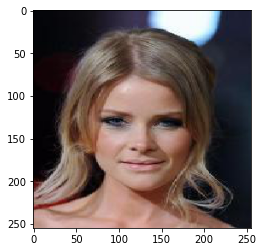

In [14]:
# set variables 
images_folder = '../Datasets/celeba/img/'
EXAMPLE_PIC = images_folder + '9.jpg'

# plot picture and attributes
#img = load_img(EXAMPLE_PIC)
#target_size=(218, 178) => target_size=(255,255): equalize the dimensions for simplicity
img = load_img(EXAMPLE_PIC,target_size=(255,255))
plt.imshow(img)
print("Gender: ",dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['gender'])

x_arr = img_to_array(img)/255.
print(x_arr.shape)
x = x_arr.reshape((1,)+x_arr.shape)
print(x.shape)
x = x.flatten()
print(x.shape)

#getdata() returns the contents of this image as a sequence object containing pixel values
pix_val = list(img.getdata())
print("Total pixels:",len(pix_val))

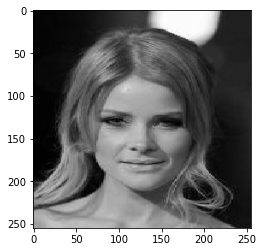

(255, 255)
(1, 255, 255)
(65025,)
Total pixels: 65025


In [15]:
gray = rgb2gray(x_arr)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
print(gray.shape)
x = gray.reshape((1,)+gray.shape)
print(x.shape)
x = x.flatten()
print(x.shape)

#getdata() returns the contents of this image as a sequence object containing pixel values
pix_val = list(img.getdata())
print("Total pixels:",len(pix_val))

In [16]:
x = img_to_array(img)/255.
print(x.shape)
x = x.reshape((1,)+x.shape)
x=x.flatten()
x=x.reshape(255,255,3)
print(x.shape)

(255, 255, 3)
(255, 255, 3)


In [17]:
females = dataset[dataset['gender']==-1].count()[0]
males = dataset[dataset['gender']==1].count()[0]
print('Females: {}  | Males: {}'.format(females,males))
print("Balanced Dataset!!")

Females: 2500  | Males: 2500
Balanced Dataset!!


## Convert images dataframe to reshaped array images dataframe

In [18]:
size=(100,100) #minimize dimensions for simplicity since after experiment original image size do not outperform the minimized one.
grayscale=False
reshaped_images=create_flattened_dataset(images,size,grayscale)

Dataset type before stacking rows: <class 'pandas.core.series.Series'> with shape: (5000,)
Dataset type after stacking rows: <class 'numpy.ndarray'> with shape: (5000, 30000)
Convert 2D np array to pd again...


**Check for NaN values**

In [19]:
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


**Train, Dev, Test split** 

In [20]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images, labels)
#convert label -1 to 0 for females for compatibility to DNN (sigmoid ans softmax functions)
y_train=y_train.replace(-1,0)
y_dev=y_dev.replace(-1,0)
y_test=y_test.replace(-1,0)

Train Set: (3500, 30000) | Dev Set: (750, 30000) | Test Set: (750, 30000)


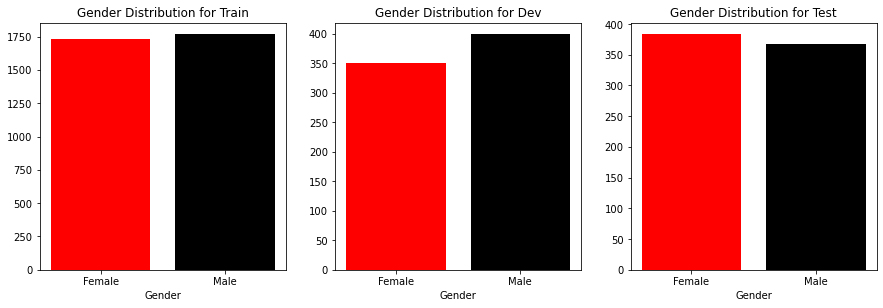

In [21]:
plot_splitted_dataset_distribution(y_train, y_test, y_dev)

# Baseline Classification Estimator with Flattened Data

## 1. kNN Classifier

The k-NN rule is a very simple learning algorithm that relies on the assumption
that “things that look alike must be alike.” 

Through cross-validation we search for the optimal k parameter:

5
10
15
20
25
30
35
40
45


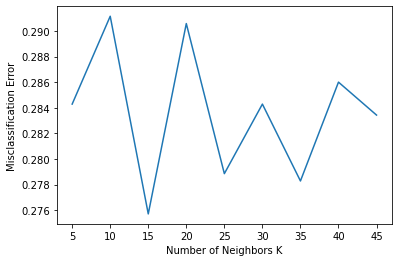

The optimal number of neighbors (calculated in the training set) is 15

Optimal accuracy on the test set is 0.712 with k= 15


In [54]:
myList = list(range(1,50))
neighbors_l = list(filter(lambda x: x % 5 == 0, myList))
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in neighbors_l:
    print(k)
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

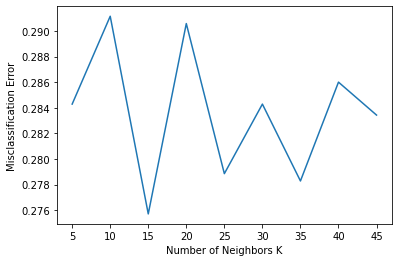

The optimal number of neighbors (calculated in the training set) is 15
              precision    recall  f1-score   support

          -1       0.66      0.80      0.72       351
           1       0.79      0.63      0.70       399

    accuracy                           0.71       750
   macro avg       0.72      0.72      0.71       750
weighted avg       0.73      0.71      0.71       750


Accuracy Score:  71.200%


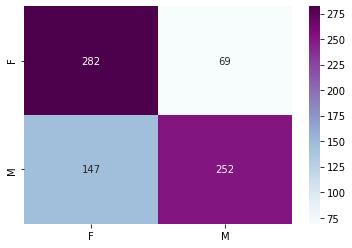

In [55]:
mean_error = [1 - x for x in cv_scores]

# plot misclassification error vs k
plt.plot(neighbors_l, mean_error)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

# determining best k
optimal_k = neighbors_l[mean_error.index(min(mean_error))]
print("The optimal number of neighbors (calculated in the training set) is %d" % optimal_k)

# για το optimal k παίρνουμε και τα αποτέλεσματα στο test set
knn = neighbors.KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(X_train, y_train)
preds_kNN = knn.predict(X_dev)
acc_kNN = Print_Classification_Results(y_dev,preds_kNN)

## 2. Linear SVM

The most basic way to use a SVM is with a linear kernel, which means the decision boundary is a straight line (or hyperplane in higher dimensions like here).

Total runtime:  271.2469599246979
              precision    recall  f1-score   support

          -1       0.87      0.90      0.88       351
           1       0.91      0.88      0.89       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  88.933%


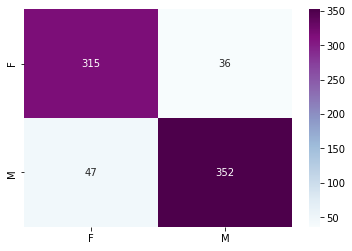

In [160]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train, y_train)
preds_svm_linear = clf_svm_linear.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_Linear_SVM = Print_Classification_Results(y_dev,preds_svm_linear)

## 3. RBF SVM
The RBF kernel SVM decision region is actually also a linear decision region. What RBF kernel SVM actually does is to create non-linear combinations of your features to uplift your samples onto a higher-dimensional feature space where you can use a linear decision boundary to separate your classes:
https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

* **Gamma**:
gamma is a parameter of the RBF kernel and can be thought of as the ‘spread’ of the kernel and therefore the decision region. When gamma is low, the ‘curve’ of the decision boundary is very low and thus the decision region is very broad. When gamma is high, the ‘curve’ of the decision boundary is high, which creates islands of decision-boundaries around data points.

* **C**:
C is a parameter of the SVC learner and is the penalty for misclassifying a data point. When C is small, the classifier is okay with misclassified data points (high bias, low variance). When C is large, the classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance).

https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/

Since we have high dimensional samples that have not been yet reduced, the cross-validation in grid search method is eschewed because of expensive training and prediction.
Hence wy experience with **some values by hand** just to infer if *rbf kernel* fits well.

In [18]:
best_score = 0
for gamma in [0.001, 0.01, 0.1]:
    for C in [1, 10, 100]:
        # for each combination of parameters, train a SVC
        svm = SVC(kernel='rbf',gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the dev set
        score = svm.score(X_dev, y_dev)
        parameters={'C':C,'gamma':gamma}
        print("Score: {:.2f}".format(score), "for Parameters: {}".format(parameters))
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("\nBest score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))
acc_rbf_SVM = best_score

Score: 0.85 for Parameters: {'C': 1, 'gamma': 0.001}
Score: 0.85 for Parameters: {'C': 10, 'gamma': 0.001}
Score: 0.85 for Parameters: {'C': 100, 'gamma': 0.001}
Score: 0.47 for Parameters: {'C': 1, 'gamma': 0.01}
Score: 0.48 for Parameters: {'C': 10, 'gamma': 0.01}
Score: 0.48 for Parameters: {'C': 100, 'gamma': 0.01}
Score: 0.47 for Parameters: {'C': 1, 'gamma': 0.1}
Score: 0.47 for Parameters: {'C': 10, 'gamma': 0.1}
Score: 0.47 for Parameters: {'C': 100, 'gamma': 0.1}

Best score: 0.85
Best parameters: {'C': 10, 'gamma': 0.001}


Now, it looks like both linear and RBF kernel SVM would work almost equally well on this dataset. So, why prefer the simpler, linear hypothesis? Think of Occam's Razor in this particular case. Linear SVM is a parametric model, an RBF kernel SVM isn't, and the complexity of the latter grows with the size of the training set. Not only is it more expensive to train an RBF kernel SVM, but you also have to keep the kernel matrix around, and the projection into this "infinite" higher dimensional space where the data becomes linearly separable is more expensive as well during prediction. Furthermore, you have more hyperparameters to tune, so model selection is more expensive as well! And finally, it's much easier to overfit a complex model!
https://www.kdnuggets.com/2016/06/select-support-vector-machine-kernels.html

## 4. Logistic Regression

Total runtime:  85.1919367313385 s
              precision    recall  f1-score   support

          -1       0.87      0.91      0.89       351
           1       0.92      0.88      0.90       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.333%


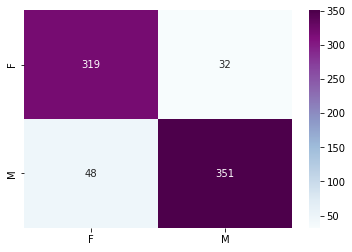

In [188]:
#For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and
#‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

clf_lr = LogisticRegression(solver='liblinear')
start_time = time.time()
# Train the model using the training sets
clf_lr.fit(X_train, y_train)
preds_lr= clf_lr.predict(X_dev)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr = Print_Classification_Results(y_dev,preds_lr)

## Final Baseline Classifier

Comparing the accuracies and the time and space used for each classifier we end up in **Logistic Regression Classifier**. Although LR and Linear SVM have same performance, LR saves computational cost and time, contrary to SVM, whose Support Vectors need a lot of computational space. https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16

In [57]:
data={'kNN (k=15)':[accuracy_score(y_dev, preds_kNN)],'Linear SVM':[accuracy_score(y_dev, preds_svm_linear)],
      'SVM rbf {}'.format(best_parameters):[best_score],'Logistic Regression':[accuracy_score(y_dev, preds_lr)]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)

,Accuracy Score
Linear SVM,0.889333
Logistic Regression,0.889333
"SVM rbf {'C': 10, 'gamma': 0.001}",0.850000
kNN (k=15),0.712000


# Preproccessing Data

## A. Converting rgb images to gray scale

Hence, initial dimensions are divided by 3. We perform this to simplify our model and check if rgb scale affects the classification process.

**We must keep in mind that each features increases the data set requirement exponentially.**

Dataset type before stacking rows: <class 'pandas.core.series.Series'> with shape: (5000,)
Dataset type after stacking rows: <class 'numpy.ndarray'> with shape: (5000, 10000)
Convert 2D np array to pd again...
Train Set: (3500, 10000) | Dev Set: (750, 10000) | Test Set: (750, 10000)
              precision    recall  f1-score   support

          -1       0.83      0.85      0.84       351
           1       0.87      0.85      0.86       399

    accuracy                           0.85       750
   macro avg       0.85      0.85      0.85       750
weighted avg       0.85      0.85      0.85       750


Accuracy Score:  84.933%


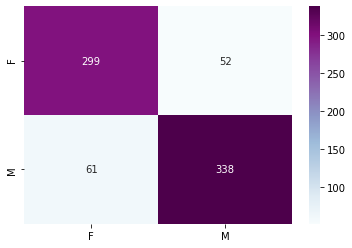

In [50]:
size=(100,100)
grayscale=True
reshaped_images_g=create_flattened_dataset(images,size,grayscale)
X_train_g, X_test_g, X_dev_g, y_train_g, y_test_g, y_dev_g=train_dev_test_split(reshaped_images_g, labels)

clf_lr_gray =  LogisticRegression(n_jobs=-1)
clf_lr_gray.fit(X_train_g, y_train_g)
preds_lr_gray = clf_lr_gray.predict(X_dev_g)
acc_gray_lr = Print_Classification_Results(y_dev_g,preds_lr_gray)

**No enhancement so we keep up with rgb scale**

## B. Curse of Dimensionality

The curse of dimensionality refers to the phenomena that occur when classifying, organizing, and analyzing high dimensional data that does not occur in low dimensional spaces, specifically the issue of data sparsity and “closeness” of data.

Sparsity of data occurs when moving to higher dimensions. the volume of the space represented grows so quickly that the data cannot keep up and thus becomes sparse.

"As the number of features or dimensions grows, the amount of data we need to generalize accurately grows exponentially."
-Charles Isbell, Professor and Senior Associate Dean, School of Interactive Computing, Georgia Tech

Value added by additional dimension is much smaller compared to overhead it adds to the algorithm.

Using too many features compared to fewer samples results in overfitting. The classifier starts learning exceptions that are specific to the training data and do not generalize well when new data is encountered.

### B1. Feature Selection

If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.

We have to set an arbitrarily variance threshold by examining the distribution of all features variance to determine which features to be remove. And, using the accuracy of the predictions as a result of a feature removal to prove that justification for feature removal is correct. Basically, its a trial and error.

In [122]:
Xvar = np.var(X_train, axis=0)
#print(np.sort(Xvar))

variance_lower_limit=0.06
X_train_reduced, X_dev_reduced=feature_selection(X_train, X_dev,variance_lower_limit)
kernel='linear'
gamma='auto'
C=1.0 #default
clf = svm.SVC(kernel=kernel, C=C, gamma=gamma)
clf.fit(X_train_reduced, y_train)
preds = clf.predict(X_dev_reduced)
print(classification_report(y_dev, preds))
print("\nAccuracy Score: ","{:.0%}".format(accuracy_score(y_dev, preds)))

train_reduced shape:  (3500, 22236)
dev_reduced shape:  (750, 22236)
              precision    recall  f1-score   support

          -1       0.64      0.71      0.67       351
           1       0.72      0.65      0.68       399

    accuracy                           0.68       750
   macro avg       0.68      0.68      0.68       750
weighted avg       0.68      0.68      0.68       750


Accuracy Score:  68%


***In this occassion, this method does not apply effectively since our dataset consists of images taken under different environmental circumstances, with variations in position, size and position, hence background for example does not follow small fluctuations so as to be removed.***

### B2. Feature Extraction - *PCA* 

(3500, 30000)
(3500, 3000)
[0.34776506 0.4177217  0.4774857  ... 0.9990582  0.9990609  0.9990637 ]


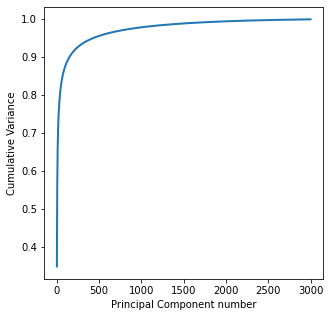

In [131]:
n = 3000
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)
print(X_train.shape)
print(X_train_PCA.shape)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

From this plot we can infer what amount of variance is represented by the corresponding number of PCA components.
Hence, almost 90% of the information given from features can be represented by n_pca=500 new features.

##### Linear SVM

(3500, 30000)
(3500, 3000)
Total runtime:  27.964019298553467 s
              precision    recall  f1-score   support

          -1       0.88      0.90      0.89       351
           1       0.91      0.89      0.90       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.200%


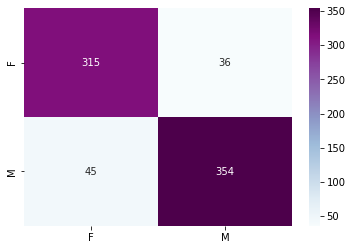

In [196]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_pca = SVC(kernel=kernel,gamma=gamma, C=C)
start_time=time.time()
clf_pca.fit(X_train_PCA, y_train)
preds_pca = clf_pca.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
acc_Linear_SVM_PCA = Print_Classification_Results(y_dev,preds_pca)

##### Logistic Regression

##### GridSearch

We perform ***GridSearch with cross-validation*** to highlight the best combination of parameters:

C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\imblearn\pipeline.py:233: UserWarning: Persisting input arguments took 3.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name]
C:\Users\xenia\anaconda3\envs\assignment\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(memory='tmp',
         steps=[('pca', PCA(n_components=2800)),
                ('LR', LogisticRegression(n_jobs=-1, solver='saga'))])
{'LR__solver': 'saga', 'pca__n_components': 2800}
              precision    recall  f1-score   support

          -1       0.88      0.89      0.88       351
           1       0.90      0.90      0.90       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.200%


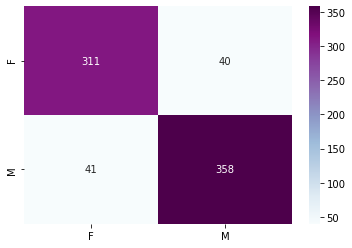

In [23]:
n_components = [100, 500, 1000,1500, 2000, 2500, 2800,3000]
solver=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
pca = PCA()
clf = LogisticRegression(n_jobs=-1)
pipe = Pipeline(steps=[('pca', pca), ('LR', clf)], memory = 'tmp')
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, LR__solver=solver), cv=5, scoring='f1_macro', n_jobs=-1)
estimator.fit(X_train, y_train)
preds = estimator.predict(X_dev)
print(estimator.best_estimator_)
print(estimator.best_params_)
Print_Classification_Results(y_dev,preds)

##### Best performing Logistic Regression

Test some models with similar parameters on our full train data:

Total runtime:  6.789927959442139 s
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       351
           1       0.91      0.89      0.90       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.333%


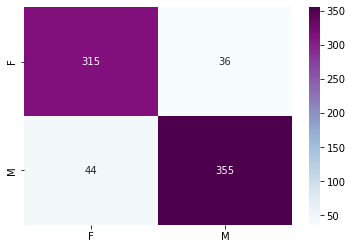

In [64]:
clf_lr_pca = LogisticRegression(solver='liblinear')
# Train the model using the training sets
start_time=time.time()
clf_lr_pca.fit(X_train_PCA, y_train)
preds_lr_pca= clf_lr_pca.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr_PCA = Print_Classification_Results(y_dev,preds_lr_pca)

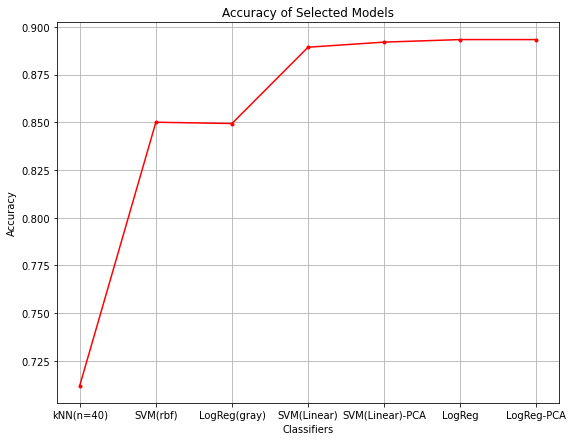

In [29]:
accuracies = [acc_kNN,acc_rbf_SVM,acc_gray_lr,acc_Linear_SVM,acc_Linear_SVM_PCA,acc_lr,acc_lr_PCA]
acc_list=["kNN(n=40)","SVM(rbf)","LogReg(gray)","SVM(Linear)","SVM(Linear)-PCA","LogReg","LogReg-PCA"]
plt.figure(figsize=(9,7))

plt.title('Accuracy of Selected Models')
plt.plot(acc_list,accuracies, 'r.-')
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.grid()
plt.show()

##### Plot images with true label and prediction label from the best pipeline model

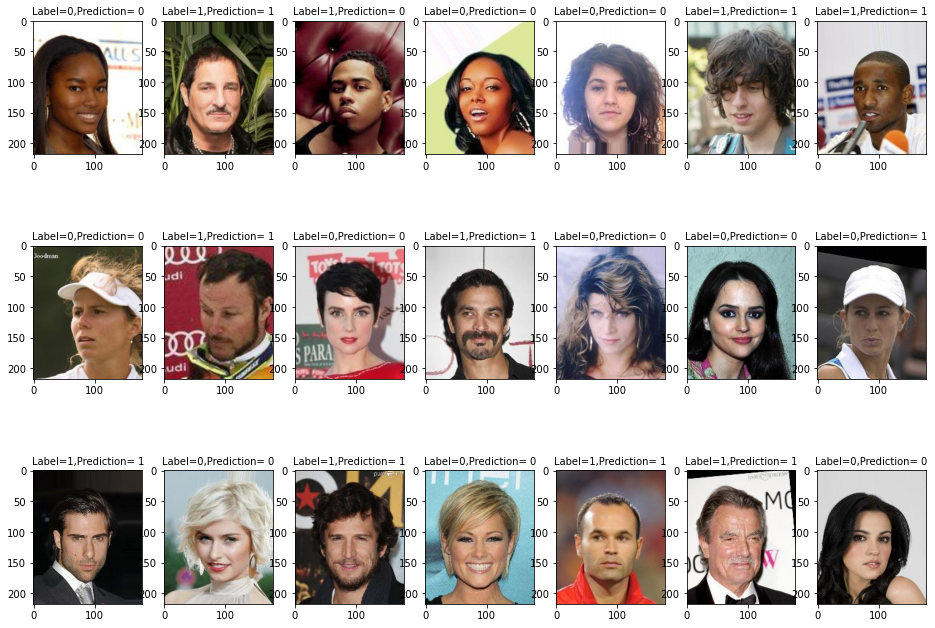

In [69]:
plot_images_true_predicted_gender(X_dev,y_dev,preds_lr_pca,images_folder)

# DNN with flattened data

In [133]:
#keras model
model = Sequential()
model.add(Dense(units =512 , activation = 'relu', input_dim=X_train_PCA.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer ='adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()
history = model.fit(X_train_PCA, y_train, batch_size=300, epochs=10, validation_data=(X_dev_PCA, y_dev))
y_pred_dnn = model.predict_classes(X_dev_PCA)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               1536512   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 1,569,409
Trainable params: 1,569,409
Non-trainable params: 0
_________________________________________________________________
Train on 3500 samples, validate on 750 samples
Epoch 1/10
3500/3500 [==============================] - 1s 197us/step - loss: 0.5569 - accuracy: 0.7137 - val_loss: 0.3897 - val_accuracy: 0.8133
Epoch 2/10
3500/3500 [==========================

['loss', 'accuracy']
Train: 1.000, Dev: 0.885


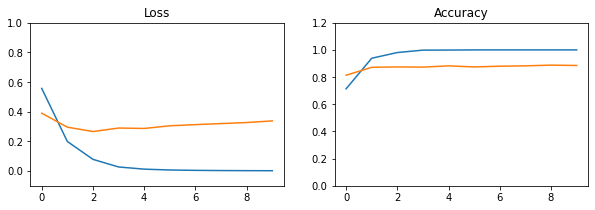

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       351
           1       0.91      0.87      0.89       399

    accuracy                           0.89       750
   macro avg       0.88      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  88.533%


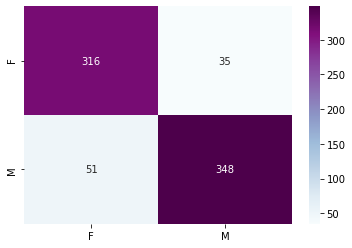

In [134]:
# evaluate the model
acc_dnn_PCA = evaluate_and_plot(model, history, X_train_PCA, y_train, X_dev_PCA, y_dev, y_pred_dnn)

# CNN with reduced image scale

Modern deep learning algorithms, such as the convolutional neural network, or CNN, can learn features that are invariant to their location in the image. Nevertheless, augmentation can further aid in this transform invariant approach to learning and can aid the model in learning features that are also invariant to transforms such as left-to-right to top-to-bottom ordering, light levels in photographs, and more.

The design of our CNN is as follows: the CNN model receives input images of size 100x100x3 (the images have three color channels).
The input data goes through four convolutional layers to make 32, 64, 128, and 256 feature maps using filters with kernel a size of 3x3. The first three convolution layers are followed by max-pooling, . Two dropout layers are also included for regularization:

Before:  (3500, 30000) (750, 30000)
After:  (3500, 100, 100, 3) (750, 100, 100, 3)


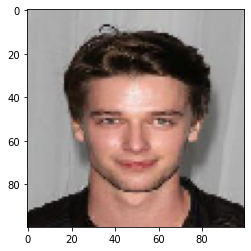

In [21]:
#reshape images to rgb
X_train_ = X_train.to_numpy()
X_dev_ = X_dev.to_numpy()
print('Before: ', X_train_.shape, X_dev_.shape)
X_train_=X_train_.reshape((X_train_.shape[0], 100, 100, 3))
X_dev_=X_dev_.reshape((X_dev_.shape[0], 100, 100, 3))
print('After: ', X_train_.shape, X_dev_.shape)
plt.imshow(X_train_[0])

In [195]:
print('Build model...')
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))         
model.add(GlobalAveragePooling2D())    
          
model.add(Dense(1, activation='sigmoid'))
# Compile the network :
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

history=model.fit(X_train_, y_train, validation_data=(X_dev_, y_dev), batch_size=400, epochs=30, verbose=1)
y_pred_cnn = model.predict_classes(X_dev_)
print(model.metrics_names)
print(model.evaluate(X_train_, y_train))

Build model...
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 25

['loss', 'accuracy']
Train: 0.777, Dev: 0.760


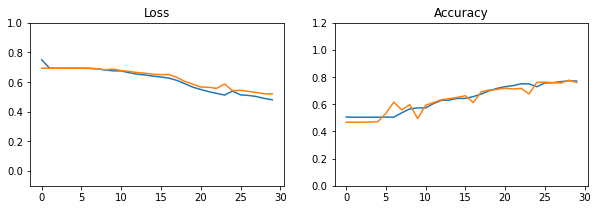

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       351
           1       0.82      0.70      0.76       399

    accuracy                           0.76       750
   macro avg       0.76      0.76      0.76       750
weighted avg       0.77      0.76      0.76       750


Accuracy Score:  76.000%


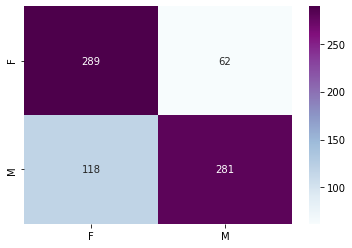

In [196]:
acc_cnn = evaluate_and_plot(model, history, X_train_, y_train, X_dev_, y_dev, y_pred_cnn)

# Data Augmentation

**Regularization:** (https://medium.com/analytics-vidhya/dense-or-convolutional-part-1-c75c59c5b4ad)

Regularization is a set of techniques to speed up the convergence during training and to avoid overfitting. There are a few families of regularization:
* Dropout in NN: for each batch, a random portion of the outputs are nullified in order to avoid strong dependencies between portions of adjacent layers. This technique is similar to boosting techniques on decision trees.We'll that in CNN
("Dropout: A Simple Way to Prevent Neural Networks from Overfitting, Nitish Srivastava et al. — http://jmlr.org/papers/v15/srivastava14a.html")
* Data augmentation: more training samples are created from existing one through geometrical transformations (translation, scaling, rotation…) or filters (blur).


However, in order to improve the generalization performance and reduce overfitting on such a small dataset, we will use a technique called data augmentation. Data augmentation summarizes a broad set of techniques for dealing with cases where the training data is limited. For instance, certain data augmentation techniques allow us to modify or even artificially synthesize more data and thereby boost the performance of a machine or deep learning model by reducing overfitting:***Chapter 15: Classifying Images with Deep Convolutional Neural Networks
Book: "Python Machine Learning, Third Edition"*** :

Because the augmentations are performed randomly, this allows both modified images and close facsimiles of the original images (e.g. almost no augmentation) to be generated and used during training. https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
For example, a random bounding box (where the coordinates of the upper-left corner are selected randomly) can be cropped from an image, an image can be randomly flipped along either the horizontal or vertical axes with a probability of 0.5, or the contrast of an image can be changed randomly, where the contrast_factor is selected at random, but with uniform distribution, from a range of values. In addition, we can create a pipeline of these transformations.

https://keras.io/api/preprocessing/image/#imagedatagenerator-class

In [22]:
#create a image generator for augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

## Example of Image Augmentation

(1, 255, 255, 3)


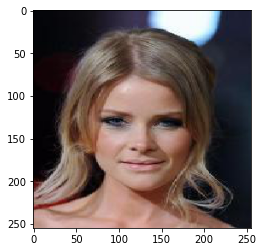

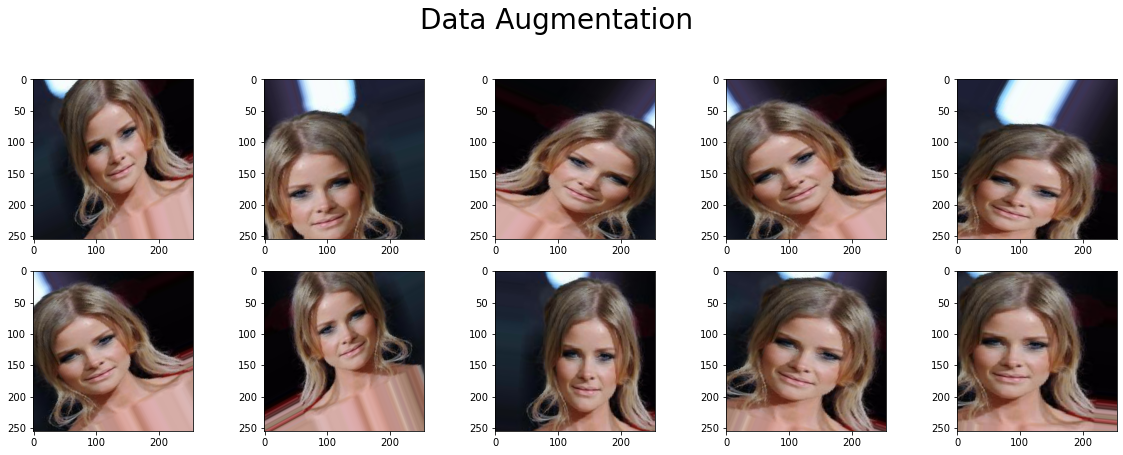

In [23]:
images_folder = '../Datasets/celeba/img/'
EXAMPLE_PIC = images_folder + '9.jpg'
img = load_img(EXAMPLE_PIC,target_size=(255,255))
plt.imshow(img)
x_arr = img_to_array(img)/255.
img = x_arr.reshape((1,)+x_arr.shape)
print(img.shape)

plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)
i = 0

for batch in datagen.flow(img, batch_size=32):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(255, 255, 3));   
    if i == 9:
        break
    i += 1   
plt.show()

## 1. Create new Train Dataset with Augmented Training Samples

Data augmentation is only used as a technique for artificially extending the training dataset in order to improve model performance on an unaugmented dataset

In [15]:
augm_images = pd.DataFrame()
augm_labels = pd.DataFrame()
size=(100,100)
for i in range(X_train.shape[0]):
    img_name=images_folder + str(X_train.index[i]) + '.jpg'
    img = load_img(img_name, target_size=size)
    x = img_to_array(img)/255.
    x = x.reshape((1,)+x.shape)
    img_vector = x.flatten()
    augm_images = augm_images.append(pd.Series(img_vector), ignore_index=True)
    augm_labels = augm_labels.append(pd.Series(y_train.iloc[i]), ignore_index=True)
    k = 0
    # create iterator
    for batch in datagen.flow(x):
        img = batch.reshape(100,100, 3)
        img_vector_batch = load_reshape_img(img,grayscale)
        augm_images=augm_images.append(pd.Series(img_vector_batch), ignore_index=True)
        augm_labels = augm_labels.append(pd.Series(y_train.iloc[i]), ignore_index=True)
        k+=1
        if k==2:
            break;
            
#augm_images.to_csv('../Datasets/celeba/augm_images.csv', index=False, header=True)
#augm_labels.to_csv('../Datasets/celeba/augm_labels.csv', index=False, header=True)

In [104]:
X_train_augm = pd.read_csv('../Datasets/celeba/augm_images.csv')
print("Dataset Size: ",augm_images_df.shape)
y_train_augm = pd.read_csv('../Datasets/celeba/augm_labels.csv')
print("Dataset Size: ",augm_labels_df.shape)

Dataset Size:  (10500, 30000)
Dataset Size:  (10500, 1)


In [113]:
train_augm_concat = pd.concat([X_train_augm,y_train_augm], axis=1, sort=False)
train_augm_concat = train_augm_concat.sample(frac=1).reset_index(drop=True)
X_train_augm =  train_augm_concat.iloc[:,:-1]
print(X_train_augm_.shape)
y_train_augm =  train_augm_concat.iloc[:,-1]
print(y_train_augm_.shape)

(10500, 30000)
(10500,)


### Evaluate the best model's efficiency (PCA LogReg) fed with augmented train set

(10500, 30000)
(10500, 3000)
[0.71578176 0.77095613 0.7936967  ... 0.99962799 0.99962891 0.99962982]


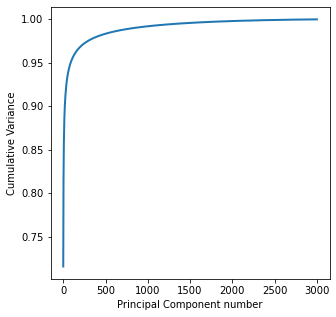

In [116]:
n = 3000 #25
pca = PCA(n_components=n)
X_train_augm_PCA = pca.fit_transform(X_train_augm)
X_dev_PCA = pca.transform(X_dev)
print(X_train_augm.shape)
print(X_train_augm_PCA.shape)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

Total runtime:  33.92927050590515 s
              precision    recall  f1-score   support

          -1       0.85      0.89      0.87       351
           1       0.90      0.86      0.88       399

    accuracy                           0.87       750
   macro avg       0.87      0.88      0.87       750
weighted avg       0.88      0.87      0.87       750


Accuracy Score:  87.467%


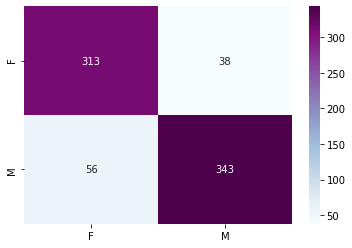

In [118]:
#y_train_augm = y_train_augm.iloc[:,0]
clf_lr_pca_augm = LogisticRegression(solver='liblinear')
# Train the model using the training sets
start_time=time.time()
clf_lr_pca_augm.fit(X_train_augm_PCA, y_train_augm)
preds_lr_pca_augm= clf_lr_pca_augm.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
acc_lr_PCA_augm = Print_Classification_Results(y_dev,preds_lr_pca_augm)

But there’s a problem with this approach — we haven’t exactly increased the ability of our model to generalize.
Yes, we have increased our training data by generating additional examples, but all of these examples are based on a super small dataset.
Keep in mind that our neural network is only as good as the data it was trained on.
We cannot expect to train a NN on a small amount of data and then expect it to generalize to data it was never trained on and has never seen before.
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

## 2. CNN with In-place/on-the-fly data augmentation

Using this type of data augmentation we want to ensure that our network, when trained, sees new variations of our data at each and every epoch.
* Step 1: An input batch of images is presented to the ImageDataGenerator .
* Step 2: The ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
* Step 3: The randomly transformed batch is then returned to the calling function.

There are two important points that I want to draw your attention to:
* The ImageDataGenerator is not returning both the original data and the transformed data — the class only returns the randomly transformed data.
* We call this “in-place” and “on-the-fly” data augmentation because this augmentation is done at training time (i.e., we are not generating these examples ahead of time/prior to training).
When our model is being trained, we can think of our ImageDataGenerator class as “intercepting” the original data, randomly transforming it, and then returning it to the neural network for training, all the while the NN has no idea the data was modified!

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

Data Augmentation is a method of artificially creating a new dataset for training from the existing training dataset to improve the performance of deep learning neural networks with the amount of data available. It is a form of regularization which makes our model generalize better than before.
Here we have used a Keras ImageDataGenerator object to apply data augmentation for randomly translating, resizing, rotating, etc the images. Each new batch of our data is randomly adjusting according to the parameters supplied to ImageDataGenerator.

When we call the .fit_generator() function it makes assumptions:

* Keras is first calling the generator function(dataAugmentaion)
* Generator function(dataAugmentaion) provides a batch_size of 32 to our .fit_generator() function.
* our .fit_generator() function first accepts a batch of the dataset, then performs backpropagation on it, and then updates the weights in our model.
* For the number of epochs specified(10 in our case) the process is repeated.

.fit_generator is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.

https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

### Create new dataset with original image size = (218,178)

In [24]:
# get actual size of data
size=(218,178)
grayscale=False
reshaped_images=create_flattened_dataset(images,size,grayscale)
X_train_img, X_test_img, X_dev_img, y_train_img, y_test_img, y_dev_img=train_dev_test_split(reshaped_images, labels)
y_train_img=y_train_img.replace(-1,0)
y_dev_img=y_dev_img.replace(-1,0)
y_test_img=y_test_img.replace(-1,0)

Dataset type before stacking rows: <class 'pandas.core.series.Series'> with shape: (5000,)
Dataset type after stacking rows: <class 'numpy.ndarray'> with shape: (5000, 116412)
Convert 2D np array to pd again...
Train Set: (3500, 116412) | Dev Set: (750, 116412) | Test Set: (750, 116412)


Before:  (3500, 116412) (750, 116412)
After:  (3500, 218, 178, 3) (750, 218, 178, 3)


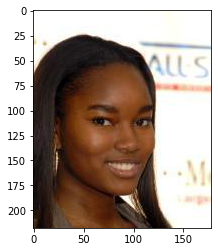

In [25]:
#reshape to RGB size to feed in the NN
X_train_img = X_train_img.to_numpy()
X_dev_img = X_dev_img.to_numpy()
X_test_img = X_test_img.to_numpy()
print('Before: ', X_train_img.shape, X_dev_img.shape)
X_train_img=X_train_img.reshape((X_train_img.shape[0], 218,178, 3))
X_dev_img=X_dev_img.reshape((X_dev_img.shape[0], 218,178, 3))
print('After: ', X_train_img.shape, X_dev_img.shape)
X_test_img=X_test_img.reshape((X_test_img.shape[0], 218,178, 3))
plt.imshow(X_dev_img[0])

### 2.1. CNN with Transfer Learning

https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b

https://www.kaggle.com/omrastogi/gender-detection-1#Build-the-Model---Gender-Recognition

https://www.kaggle.com/bmarcos/image-recognition-gender-detection-inceptionv3

In [26]:
IMG_HEIGHT = 218
IMG_WIDTH = 178
BATCH_SIZE = 100
#load pretrained model on Imagenet
pretrained_model = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(pretrained_model.layers))
#pretrained_model.summary()

number of layers: 311


In [27]:
#Adding custom Layers
pretrained_output_layer = pretrained_model.output
x = GlobalAveragePooling2D()(pretrained_output_layer)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=pretrained_model.input, outputs=output)

# Lock initial layers to do not be trained
for layer in model.layers[:311]:
    layer.trainable = False

# compile the model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9) 
              #optimizer='adam' missperform -> overfitting
              #optimizer=SGD(lr=0.0001, momentum=0.9) ->very slow convergence
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])

model.save('best.augm_models.h5')

In [28]:
#create checkpoint to store the best fitted weights
checkpointer = ModelCheckpoint(filepath='weights.best.augm_models.hdf5', 
                               verbose=1, save_best_only=True)
datagen.fit(X_train_img)

train_generator = datagen.flow(
X_train_img, y_train_img,
batch_size=BATCH_SIZE, 
)

In [63]:
#fit train augmented data in batches 
history = model.fit_generator(train_generator
                     , validation_data = (X_dev_img, y_dev_img)
                      , steps_per_epoch= X_train.shape[0]/BATCH_SIZE #this will use all of the data points, one batch size worth at a time.
                      , epochs= 20
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
35/35 [==============================] - 220s 6s/step - loss: 0.6915 - accuracy: 0.5509 - val_loss: 0.4989 - val_accuracy: 0.7960

Epoch 00001: val_loss improved from inf to 0.49892, saving model to weights.best.augm_model.hdf5
Epoch 2/20
35/35 [==============================] - 215s 6s/step - loss: 0.6206 - accuracy: 0.6729 - val_loss: 0.3728 - val_accuracy: 0.8733

Epoch 00002: val_loss improved from 0.49892 to 0.37281, saving model to weights.best.augm_model.hdf5
Epoch 3/20
35/35 [==============================] - 214s 6s/step - loss: 0.5656 - accuracy: 0.7366 - val_loss: 0.3594 - val_accuracy: 0.8387

Epoch 00003: val_loss improved from 0.37281 to 0.35937, saving model to weights.best.augm_model.hdf5
Epoch 4/20
35/35 [==============================] - 214s 6s/step - loss: 0.5164 - accuracy: 0.7760 - val_loss: 0.3437 - val_accuracy: 0.8453

Epoch 00004: val_loss improved from 0.35937 to 0.34370, saving model to weights.best.augm_model.hdf5
Epoch 5/20
35/35 [==============

['loss', 'accuracy']
Train: 0.844, Dev: 0.841


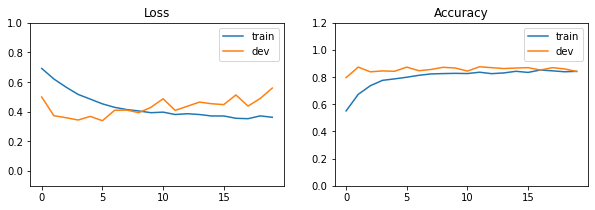

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       351
           1       0.96      0.73      0.83       399

    accuracy                           0.84       750
   macro avg       0.86      0.85      0.84       750
weighted avg       0.87      0.84      0.84       750


Accuracy Score:  84.133%


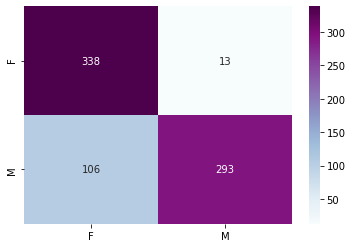

In [64]:
# evaluate the model
y_pred = model.predict(X_dev_img)
y_pred = [0 if x<0.5 else 1 for x in y_pred]
acc_cnn_augm_pretrained = evaluate_and_plot(model, history, X_train_img, y_train_img, X_dev_img, y_dev_img, y_pred)

**Evaluate model on Test Data:**

Load model...
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       383
           1       0.94      0.80      0.86       367

    accuracy                           0.88       750
   macro avg       0.89      0.87      0.87       750
weighted avg       0.88      0.88      0.88       750


Accuracy Score:  87.600%


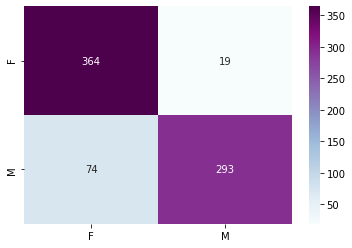

In [56]:
#load the best model
print('Load model...')
model=load_model('best.augm_model.h5')
model.load_weights('weights.best.augm_model.hdf5')
print('Predicting values...')
y_pred = model.predict(X_test_img)
y_pred = [0 if x<0.5 else 1 for x in y_pred]
accuracy = Print_Classification_Results(y_test_img,y_pred)

### 2.2. CNN built from scratch

In [55]:
print('Build model...')
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH,3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))         
model.add(GlobalAveragePooling2D())    
          
model.add(Dense(1, activation='sigmoid'))
# Compile the network :
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 218, 178, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 109, 89, 32)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 109, 89, 32)       0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 109, 89, 64)       18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 55, 45, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 55, 45, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 55,

In [58]:
checkpointer = ModelCheckpoint(filepath='weights.best.inc.hdf5', 
                               verbose=1, save_best_only=True)
datagen.fit(X_train_img)
train_generator = datagen.flow(
X_train_img, y_train_img,
BATCH_SIZE=100, # 100 data in each batch
)
hist = model.fit_generator(train_generator
                     , validation_data = (X_dev_img, y_dev_img)
                      , steps_per_epoch= X_train.shape[0]/BATCH_SIZE
                      , epochs= 20
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
35/35 [==============================] - 164s 5s/step - loss: 0.6990 - accuracy: 0.5111 - val_loss: 0.6919 - val_accuracy: 0.5267

Epoch 00001: val_loss improved from inf to 0.69188, saving model to weights.best.inc.hdf5
Epoch 2/20
35/35 [==============================] - 154s 4s/step - loss: 0.6872 - accuracy: 0.5594 - val_loss: 0.6768 - val_accuracy: 0.5867

Epoch 00002: val_loss improved from 0.69188 to 0.67684, saving model to weights.best.inc.hdf5
Epoch 3/20
35/35 [==============================] - 152s 4s/step - loss: 0.6742 - accuracy: 0.5846 - val_loss: 0.6676 - val_accuracy: 0.6093

Epoch 00003: val_loss improved from 0.67684 to 0.66761, saving model to weights.best.inc.hdf5
Epoch 4/20
35/35 [==============================] - 151s 4s/step - loss: 0.6672 - accuracy: 0.6043 - val_loss: 0.6728 - val_accuracy: 0.5760

Epoch 00004: val_loss did not improve from 0.66761
Epoch 5/20
35/35 [==============================] - 152s 4s/step - loss: 0.6575 - accuracy: 0.6149 - va

['loss', 'accuracy']
Train: 0.787, Dev: 0.753
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       351
           1       0.76      0.78      0.77       399

    accuracy                           0.75       750
   macro avg       0.75      0.75      0.75       750
weighted avg       0.75      0.75      0.75       750


Accuracy Score:  75.333%


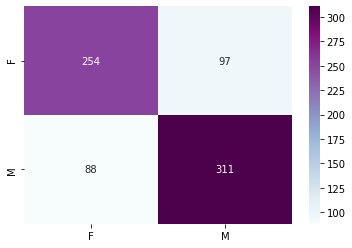

In [59]:
# evaluate the model
y_pred_cnn = model.predict_classes(X_dev_img)
print(model.metrics_names)
train_loss, train_acc = model.evaluate(X_train_img, y_train_img, verbose=0)
dev_loss, dev_acc = model.evaluate(X_dev_img, y_dev_img, verbose=0)
print('Train: %.3f, Dev: %.3f' % (train_acc, dev_acc))
acc_cnn_augm = Print_Classification_Results(y_dev_img,y_pred_cnn)

# Best performing model

## Compare models

|                     |   Accuracy Score |
|:--------------------|-----------------:|
| kNN(n=40)           |          0.712   |
| CNN                 |          0.76    |
| CNN_augm_pretrained |          0.84133 |
| LogReg(gray)        |          0.84933 |
| SVM(rbf)            |          0.85    |
| LogReg-PCA-augm     |          0.87467 |
| DNN-PCA             |          0.88533 |
| SVM(Linear)         |          0.88933 |
| SVM(Linear)-PCA     |          0.892   |
| LogReg              |          0.89333 |
| LogReg-PCA          |          0.89333 |


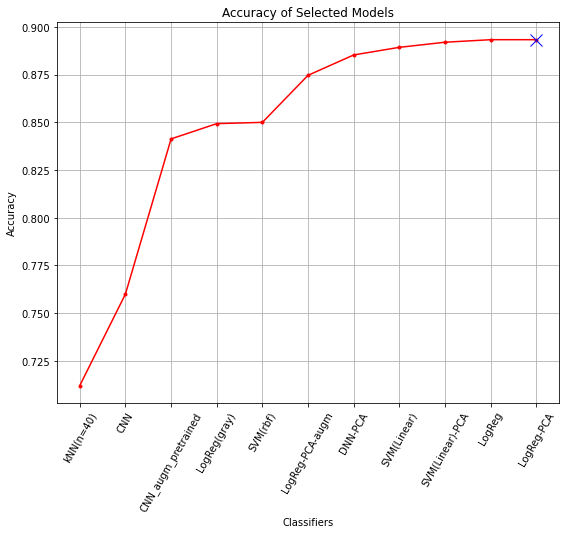

In [31]:
# acc_kNN=0.71200
# acc_cnn=0.76000
# acc_cnn_augm_pretrained=0.84133
# acc_gray_lr=0.84933
# acc_rbf_SVM=0.85000
# acc_lr_PCA_augm=0.87467
# acc_dnn_PCA=0.88533
# acc_Linear_SVM=0.88933
# acc_Linear_SVM_PCA=0.89200
# acc_lr=0.89333
# acc_lr_PCA=0.89333

data={'kNN(n=40)':[acc_kNN],'CNN':[acc_cnn],'CNN_augm_pretrained':[acc_cnn_augm_pretrained],
      'LogReg(gray)':[acc_gray_lr],'SVM(rbf)':[acc_rbf_SVM],'LogReg-PCA-augm':[acc_lr_PCA_augm],
      'DNN-PCA':[acc_dnn_PCA],'SVM(Linear)':[acc_Linear_SVM],'SVM(Linear)-PCA':[acc_Linear_SVM_PCA],
      'LogReg':[acc_lr],'LogReg-PCA':[acc_lr_PCA]}
df=pd.DataFrame.from_dict(data,orient='index',columns=['Accuracy Score'])
df.sort_values(by=df.columns[0],ascending=False, inplace=False)
print(df.to_markdown()) 

accuracies = [acc_kNN, acc_cnn, acc_cnn_augm_pretrained,acc_gray_lr, acc_rbf_SVM, acc_lr_PCA_augm,
              acc_dnn_PCA, acc_Linear_SVM,acc_Linear_SVM_PCA,acc_lr,acc_lr_PCA]
accuracies = np.array(accuracies)
acc_list=["kNN(n=40)","CNN", "CNN_augm_pretrained","LogReg(gray)","SVM(rbf)","LogReg-PCA-augm",
          "DNN-PCA", "SVM(Linear)","SVM(Linear)-PCA","LogReg","LogReg-PCA"]

plt.figure(figsize=(9,7))
plt.title('Accuracy of Selected Models')
plt.plot(acc_list,accuracies, 'r.-')

#spot maximum accuracy
acc_max = np.array(accuracies).max()
index=np.where(accuracies==acc_max)
index = index[0][1]
plt.plot(acc_list[index],acc_max,'x',color='b',markersize=12)

plt.grid()
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.xticks(rotation=60)
plt.show()

It is clear that NN techniques do not outperform on validation data since we dont have the requisite ammount of data for NN models to learn adequate patterns and extract the needed features.
Furthermore, NN have enormous computational cost comparing to simplest techniques. We can conclude from our expirements that more complex and deeper models do not outperform always the simpler ones.
However with more computational sources we could reach better results building CNN models with more layers and filters.

## Evaluate of Final model on Validation and Test Data

**Final Model**: *LogisticRegression with solver='liblinear' on transformed data through the technique of feature extraction PCA with 3000 pca components*

### Accuracy on Dev Set:

In [26]:
n = 3000
pca = PCA(n_components=n)
X_train_PCA = pca.fit_transform(X_train)
X_dev_PCA = pca.transform(X_dev)

Total runtime:  6.846661329269409 s
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       351
           1       0.91      0.89      0.90       399

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750


Accuracy Score:  89.333%


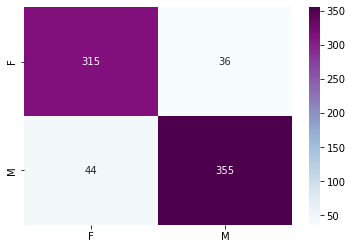

In [27]:
model_A1 = LogisticRegression(solver='liblinear')
start_time=time.time()
model_A1.fit(X_train_PCA, y_train)
y_pred= model_A1.predict(X_dev_PCA)
print("Total runtime: ",time.time()-start_time,"s")
accuracy = Print_Classification_Results(y_dev,y_pred)

In [28]:
# Save to file in the current working directory
pkl_filename = "model_A1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_A1, file)

### Accuracy on Test Set:

In [29]:
X_test_PCA = pca.transform(X_test)

Load model...
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       383
           1       0.90      0.89      0.90       367

    accuracy                           0.90       750
   macro avg       0.90      0.90      0.90       750
weighted avg       0.90      0.90      0.90       750


Accuracy Score:  89.867%


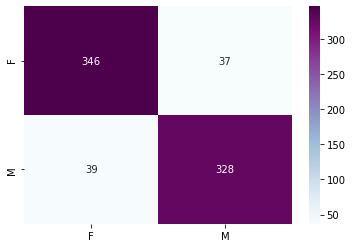

In [30]:
# Load from file
print('Load model...')
with open(pkl_filename, 'rb') as file:
    model_A1 = pickle.load(file)
    
# Calculate the accuracy score and predict target values
y_pred = model_A1.predict(X_test_PCA)
accuracy = Print_Classification_Results(y_test,y_pred)

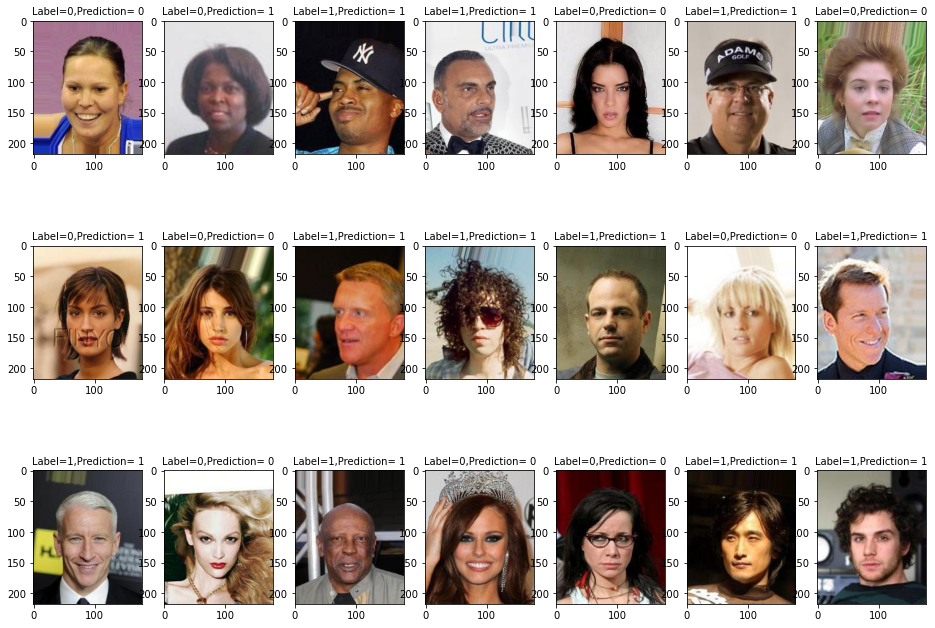

In [26]:
plot_images_true_predicted_gender(X_test,y_test,y_pred,images_folder)

### Compare Baseline and Best model's Accurracy on Test Set

**Baseline model vs Best model**

* *Estimator*: Linear SVM **vs** LogisticRegression with solver='liblinear'
* *Training Data*: Flattened images of size=(100,100) in RGB scale **vs** Flattened images of size=(100,100) in RGB scale, through the technique of feature extraction PCA with 3000 pca components which means that our model can reach better accuracy **without loosing important iformation with much smaller feature vectors**.


Accuracy Score of Test Set for Baseline Model:  88.800%

Accuracy Score of Test Set for Best Model:  89.867%


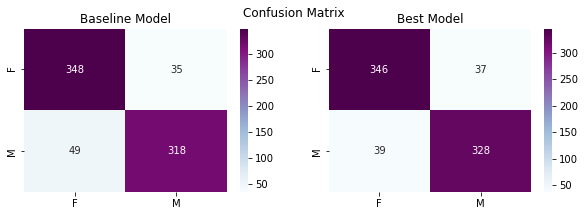

In [31]:
#Baseline model
preds_svm = clf_svm_linear.predict(X_test)
acc_lr = accuracy_score(y_test, preds_svm)
print("\nAccuracy Score of Test Set for Baseline Model: ","{:.3%}".format(acc_lr))
conf_matrix1 = confusion_matrix(y_test, preds_svm)

#Best model
preds_A1 = model_A1.predict(X_test_PCA)
accuracy_B3 = accuracy_score(y_test,preds_A1)
print("\nAccuracy Score of Test Set for Best Model: ","{:.3%}".format(accuracy_B3))
conf_matrix2 = confusion_matrix(y_test,preds_A1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Confusion Matrix', fontsize=12)
labels=['F','M']

ax1.set_title('Baseline Model')
sns.heatmap(conf_matrix1, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax1)

ax2.set_title('Best Model')
sns.heatmap(conf_matrix2, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu",ax=ax2)
plt.show()

***We have to keep in mind that if accuracy on train data is extremely high we jeopardize of having our model overfitted. 
Train and Test accuracy must follow a similar development , otherwise the only thing we achieve by acquiring higher accuracy for training data solely is overfitting.***